# Time Series Analysis on Gold

## Problem Statement

The primary objective of this project is to develop a robust forecasting model for gold prices using multiple time series analysis. By integrating a variety of economic indicators and global event data, the model aims to capture the complex dynamics that influence gold prices. Specifically, the project will evaluate how well variables such as the Federal Funds Effective Rate, U.S., the S&P 500 index, and crude oil prices (WTI) correlate with and predict the fluctuations in gold prices. The success of the model will be measured based on its accuracy and reliability in forecasting future gold price movements, thereby providing valuable insights for investors, economists, and policymakers.

*In this project we will explore the data in monthly format, if the data was originally in daily format, we will transform the data and use Month-End Value.*

In [ ]:
!pip3 install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00


In [ ]:
!pip3 install openpyxl

In [ ]:
!pip3 install xlrd

In [ ]:
!pip3 install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 7.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import sys
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from prophet import Prophet
from scipy.stats import chi2, jarque_bera
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

## Data properties (stationarity, correlations, data distribution) and Exploratory data analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Time Series Final Project/

/content/drive/My Drive/Time Series Final Project


In [ ]:
gold_price = pd.read_excel("gold_price.xlsx")
gold_price['Date'] = gold_price['Date'].dt.strftime('%Y-%m-%d') # make sure the time series
gold_price.head()

,Date,Price
0,1978-01-31,207.83
1,1978-02-28,227.27
2,1978-03-31,245.67
3,1978-04-28,242.05
4,1978-05-31,239.16


In [ ]:
fed_funds_rate = pd.read_excel("fed_funds_rate.xls")
# Transform the dataset
fed_funds_rate['observation_date'] = pd.to_datetime(fed_funds_rate['observation_date'])

fed_funds_rate.set_index('observation_date', inplace=True)

fed_funds_rate = fed_funds_rate.resample('M').last()

fed_funds_rate.reset_index(inplace=True)

fed_funds_rate.columns = ['Date', 'Price']
fed_funds_rate['Date'] = fed_funds_rate['Date'].dt.strftime('%Y-%m-%d')
fed_funds_rate.head()

,Date,Price
0,1979-01-31,10.57
1,1979-02-28,10.24
2,1979-03-31,10.07
3,1979-04-30,10.43
4,1979-05-31,10.31


In [ ]:
CPI = pd.read_excel("CPI.xls")
CPI['observation_date'] = pd.to_datetime(CPI['observation_date'])

CPI.set_index('observation_date', inplace=True)

CPI = CPI.resample('M').last()

CPI.reset_index(inplace=True)

CPI.columns = ['Date', 'Price']
CPI['Date'] = CPI['Date'].dt.strftime('%Y-%m-%d')
CPI.head()

,Date,Price
0,2010-01-31,-0.160617
1,2010-02-28,-0.120399
2,2010-03-31,-0.054216
3,2010-04-30,-0.001069
4,2010-05-31,0.026482


In [ ]:
SP500 = pd.read_excel("SP500.xls")
SP500['observation_date'] = pd.to_datetime(SP500['observation_date'])

SP500.set_index('observation_date', inplace=True)

SP500 = SP500.resample('M').last()

SP500.reset_index(inplace=True)

SP500.columns = ['Date', 'Price']
SP500['Date'] = SP500['Date'].dt.strftime('%Y-%m-%d')
SP500.head()

,Date,Price
0,2019-04-30,2945.83
1,2019-05-31,2752.06
2,2019-06-30,2941.76
3,2019-07-31,2980.38
4,2019-08-31,2926.46


In [ ]:
WTI_OIL = pd.read_excel("WTI_OIL.xls")
WTI_OIL['observation_date'] = pd.to_datetime(WTI_OIL['observation_date'])

WTI_OIL.set_index('observation_date', inplace=True)

WTI_OIL = WTI_OIL.resample('M').last()

WTI_OIL.reset_index(inplace=True)

WTI_OIL.columns = ['Date', 'Price']
WTI_OIL['Date'] = WTI_OIL['Date'].dt.strftime('%Y-%m-%d')
WTI_OIL.head()

,Date,Price
0,1986-01-31,18.95
1,1986-02-28,13.23
2,1986-03-31,10.25
3,1986-04-30,13.38
4,1986-05-31,14.30


In above part, I checked all the data properties and make sure they are all month end in order to prepare the analysis later.

### EDA of features

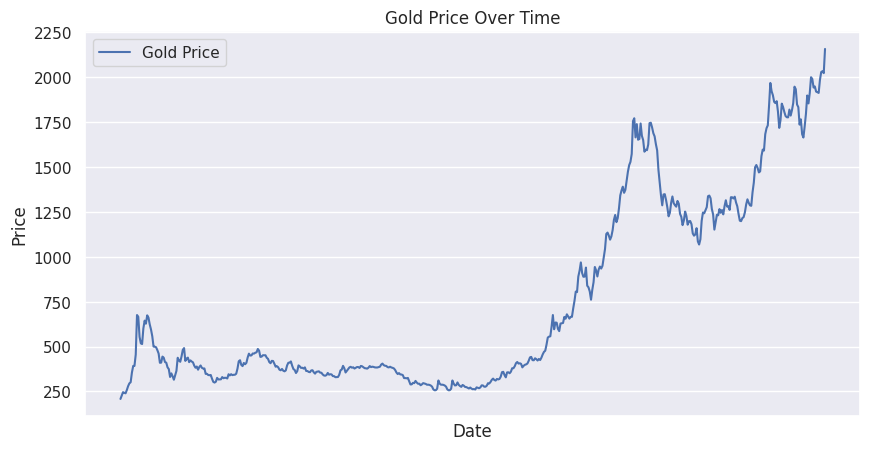

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(gold_price['Date'], gold_price['Price'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

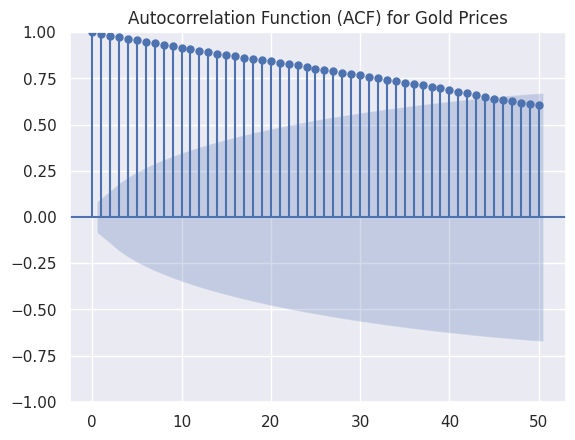

In [ ]:
plot_acf(gold_price['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Gold Prices')
plt.show()

ACF Plot - Steadily Decreasing Bars:

This pattern indicates a non-stationary time series. It suggests that future values of the series are correlated / heavily affected by past values.

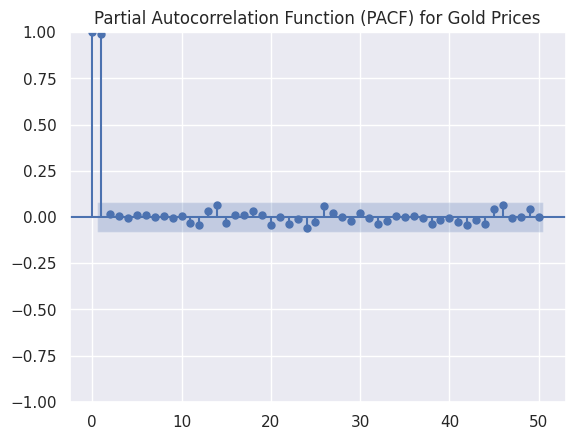

In [ ]:
plot_pacf(gold_price['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Gold Prices')
plt.show()

PACF Plot - Bars Exceeding the Significance Boundary:

Significant spikes in the PACF plot that exceed the confidence interval boundaries indicate potential lags that could be used as terms in an AR model.

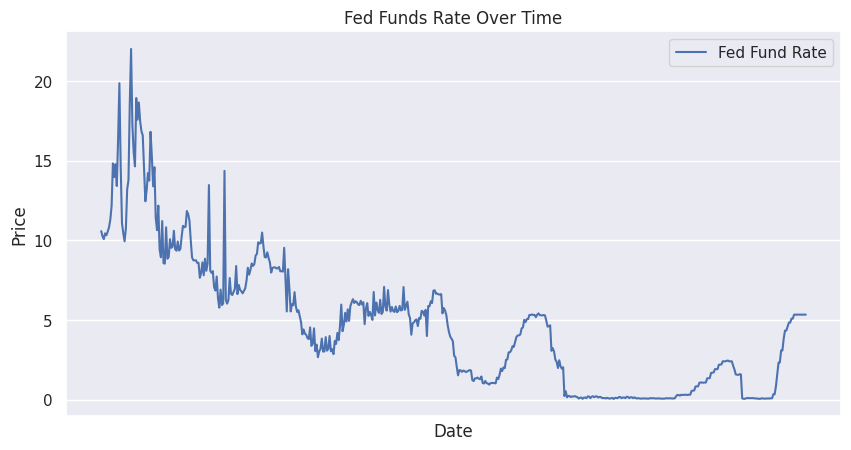

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(fed_funds_rate['Date'], fed_funds_rate['Price'], label='Fed Fund Rate')
plt.title('Fed Funds Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

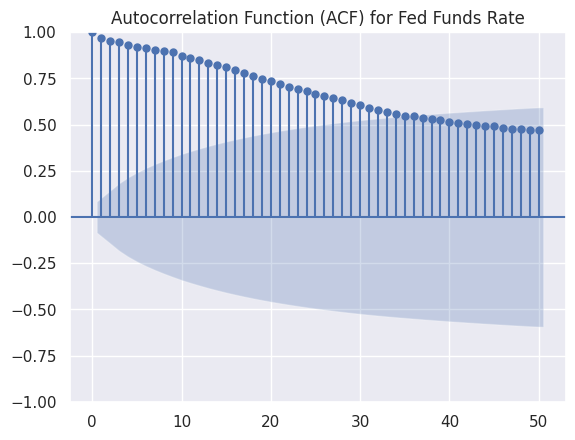

In [ ]:
plot_acf(fed_funds_rate['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Fed Funds Rate')
plt.show()

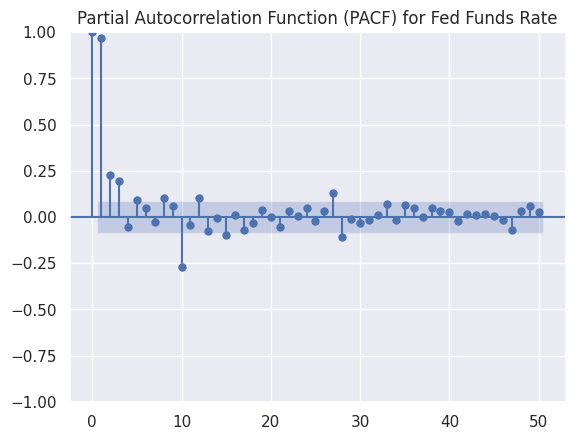

In [ ]:
plot_pacf(fed_funds_rate['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Fed Funds Rate')
plt.show()

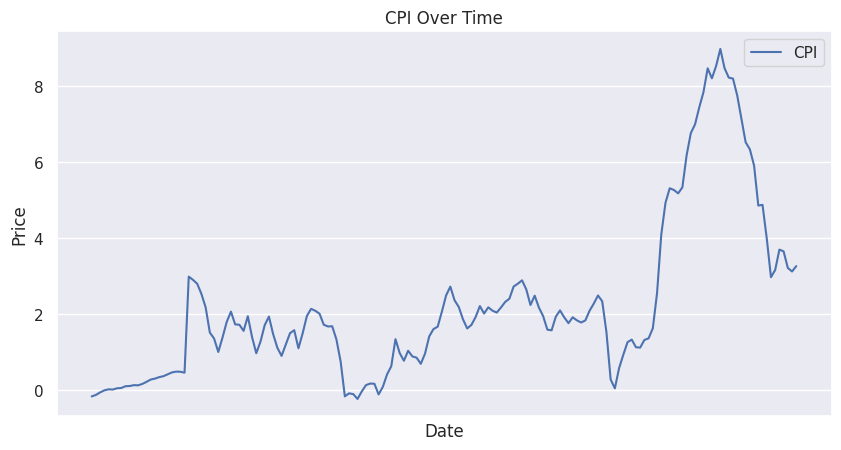

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(CPI['Date'], CPI['Price'], label='CPI')
plt.title('CPI Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

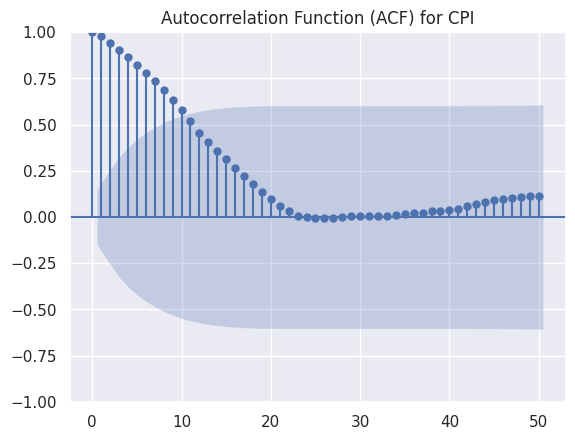

In [ ]:
plot_acf(CPI['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for CPI')
plt.show()

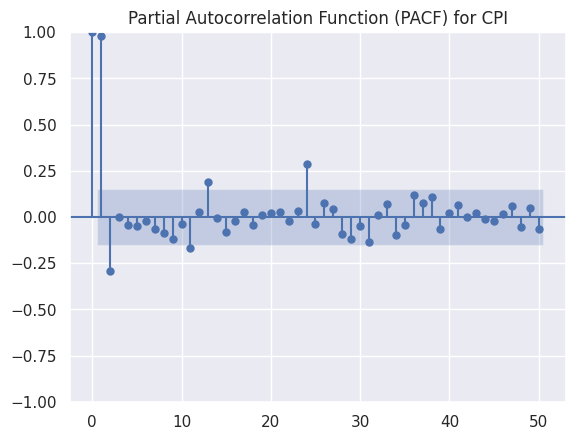

In [ ]:
plot_pacf(CPI['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for CPI')
plt.show()

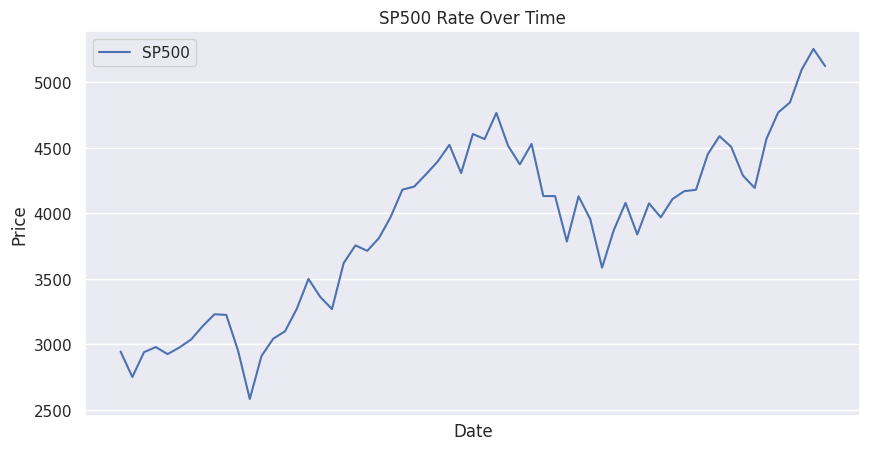

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(SP500['Date'], SP500['Price'], label='SP500')
plt.title('SP500 Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

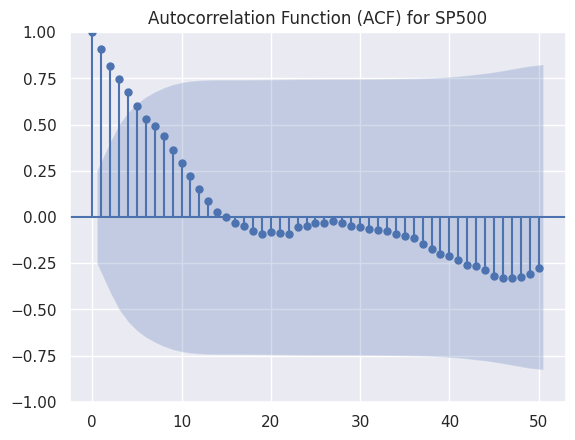

In [ ]:
plot_acf(SP500['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for SP500')
plt.show()

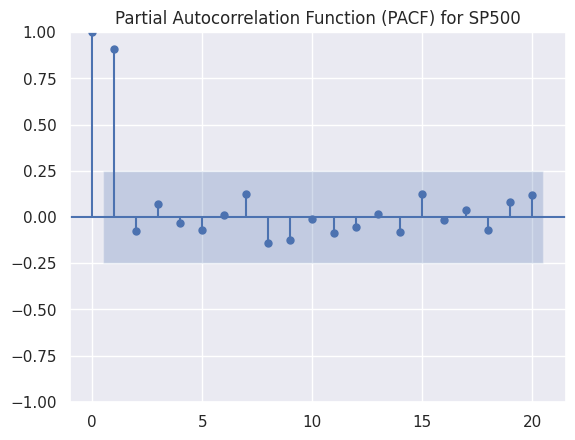

In [ ]:
plot_pacf(SP500['Price'], lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for SP500')
plt.show()

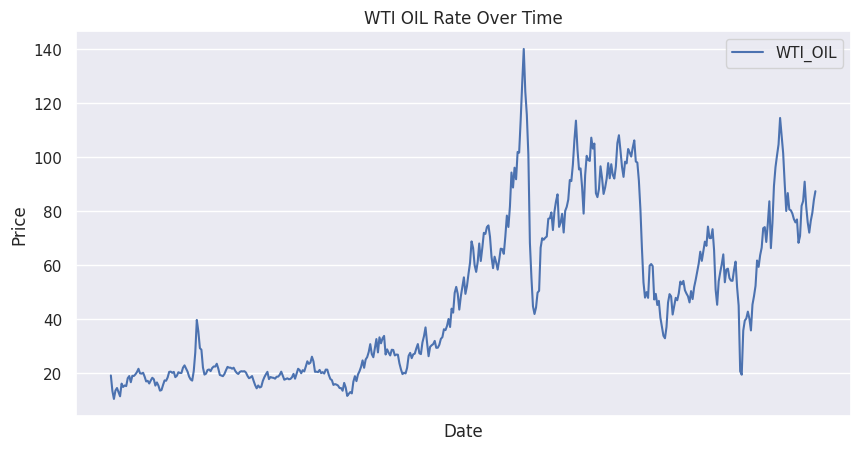

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(WTI_OIL['Date'], WTI_OIL['Price'], label='WTI_OIL')
plt.title('WTI OIL Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

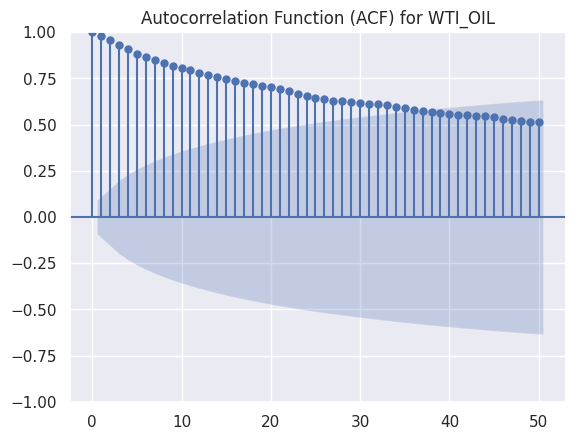

In [ ]:
plot_acf(WTI_OIL['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for WTI_OIL')
plt.show()

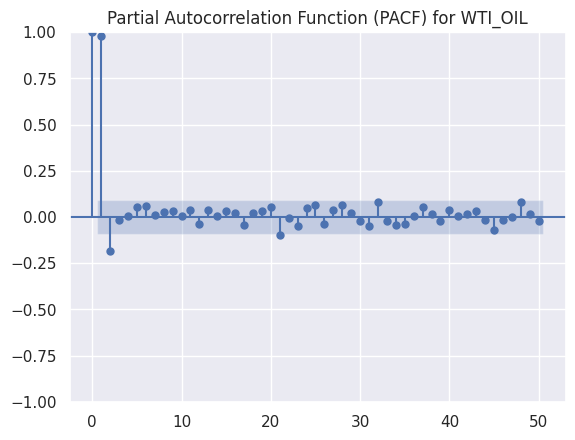

In [ ]:
plot_pacf(WTI_OIL['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for WTI_OIL')
plt.show()

## Data processing (anomaly detection, cleansing and imputations) and transformations

Here I will make sure our dataset size and length are the same.

In [ ]:
gold_price['Date'] = pd.to_datetime(gold_price['Date'])
gold_price.set_index('Date', inplace=True)
gold_price_sliced = gold_price.loc['2019-04-30':'2023-11-30']

In [ ]:
fed_funds_rate['Date'] = pd.to_datetime(fed_funds_rate['Date'])
fed_funds_rate.set_index('Date', inplace=True)
fed_funds_rate_sliced = fed_funds_rate.loc['2019-04-30':'2023-11-30']

In [ ]:
CPI['Date'] = pd.to_datetime(CPI['Date'])
CPI.set_index('Date', inplace=True)
CPI_sliced = CPI.loc['2019-04-30':'2023-11-30']

In [ ]:
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500.set_index('Date', inplace=True)
SP500_sliced = SP500.loc['2019-04-30':'2023-11-30']

In [ ]:
WTI_OIL['Date'] = pd.to_datetime(WTI_OIL['Date'])
WTI_OIL.set_index('Date', inplace=True)
WTI_OIL_sliced = WTI_OIL.loc['2019-04-30':'2023-11-30']

In [ ]:
print(len(gold_price_sliced))
print(len(fed_funds_rate_sliced))
print(len(CPI_sliced))
print(len(SP500_sliced))
print(len(WTI_OIL_sliced))

56
56
56
56
56


In [ ]:
combined_df = pd.concat([gold_price_sliced, fed_funds_rate_sliced, CPI_sliced, SP500_sliced, WTI_OIL_sliced], axis=1)

combined_df.columns = ['Gold_Price', 'Fed_Funds_Rate', 'CPI', 'SP500', 'WTI_OIL']

In [ ]:
combined_df.head()

,Gold_Price,Fed_Funds_Rate,CPI,SP500,WTI_OIL
Date,,,,,
2019-04-30,1286.45,2.45,2.099331,2945.83,63.83
2019-05-31,1283.95,2.40,1.916335,2752.06,53.49
2019-06-28,1359.04,NaN,NaN,NaN,NaN
2019-06-30,NaN,2.40,1.764365,2941.76,58.20
2019-07-31,1412.98,2.40,1.917843,2980.38,58.53


In [ ]:
# Check for Missing Values
print(combined_df.isnull().sum())

Gold_Price        15
Fed_Funds_Rate    15
CPI               15
SP500             15
WTI_OIL           15
dtype: int64


We see some NAN values, I used the before fill method to deal with the data anomaly.

In [ ]:
# using fill, may change later
combined_df.fillna(method='bfill', inplace=True)

In [ ]:
combined_df

,Gold_Price,Fed_Funds_Rate,CPI,SP500,WTI_OIL
Date,,,,,
2019-04-30,1286.45,2.45,2.099331,2945.83,63.83
2019-05-31,1283.95,2.40,1.916335,2752.06,53.49
2019-06-28,1359.04,2.40,1.764365,2941.76,58.20
2019-06-30,1412.98,2.40,1.764365,2941.76,58.20
2019-07-31,1412.98,2.40,1.917843,2980.38,58.53
...,...,...,...,...,...
2023-08-31,1920.03,5.33,3.696583,4507.66,83.55
2023-09-29,1916.96,5.33,3.650365,4288.05,90.77
2023-09-30,1913.04,5.33,3.650365,4288.05,90.77


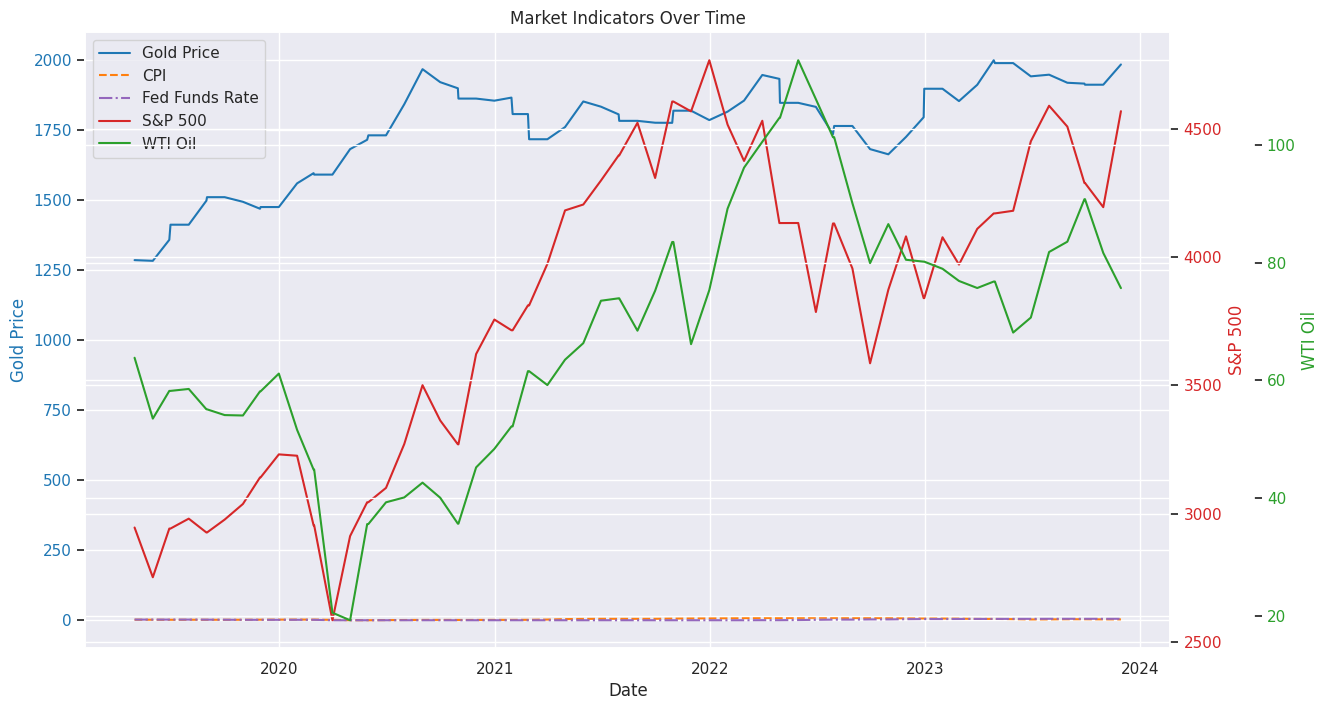

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color=color)
ax1.plot(combined_df.index, combined_df['Gold_Price'], color=color, label='Gold Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('S&P 500', color=color)
ax2.plot(combined_df.index, combined_df['SP500'], color=color, label='S&P 500')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('WTI Oil', color=color)
ax3.plot(combined_df.index, combined_df['WTI_OIL'], color=color, label='WTI Oil')
ax3.tick_params(axis='y', labelcolor=color)

ax1.plot(combined_df.index, combined_df['CPI'], color='tab:orange', linestyle='--', label='CPI')
ax1.plot(combined_df.index, combined_df['Fed_Funds_Rate'], color='tab:purple', linestyle='-.', label='Fed Funds Rate')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.title('Market Indicators Over Time')
plt.show()


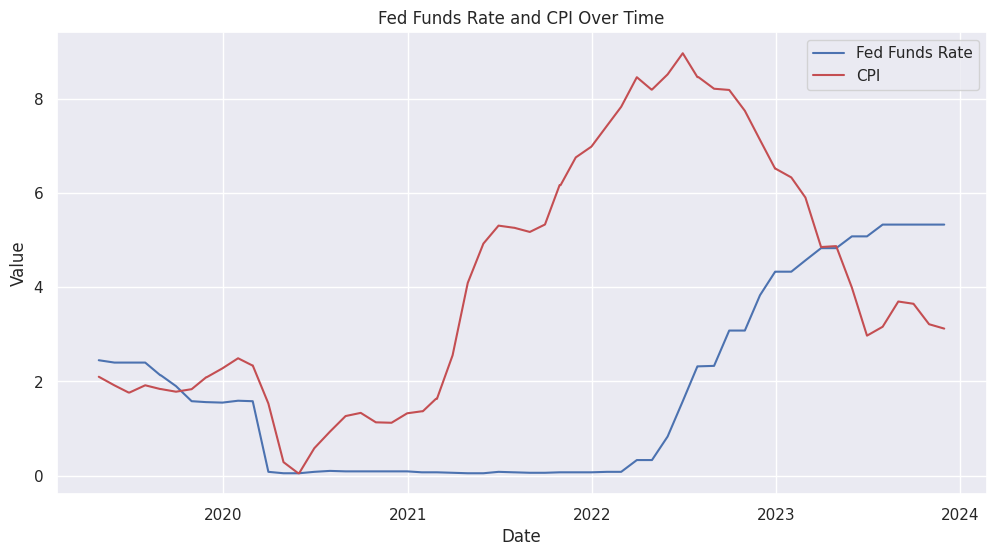

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Fed Funds Rate
plt.plot(combined_df.index, combined_df['Fed_Funds_Rate'], label='Fed Funds Rate', color='b')

# Plot CPI
plt.plot(combined_df.index, combined_df['CPI'], label='CPI', color='r')

plt.title('Fed Funds Rate and CPI Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()

plt.show()

                Gold_Price  Fed_Funds_Rate       CPI     SP500   WTI_OIL
Gold_Price        1.000000        0.152112  0.330900  0.716368  0.345616
Fed_Funds_Rate    0.152112        1.000000  0.143392  0.177329  0.346727
CPI               0.330900        0.143392  1.000000  0.661722  0.878530
SP500             0.716368        0.177329  0.661722  1.000000  0.712973
WTI_OIL           0.345616        0.346727  0.878530  0.712973  1.000000


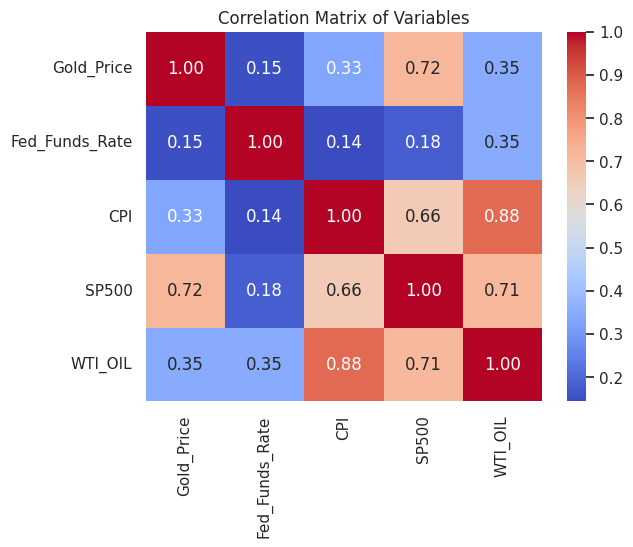

In [ ]:
correlation_matrix = combined_df.corr()

print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()


From correlation matrix, we can simply see that gold price is highly correlated to SP500.

### Check for Stationarity

In below, before doing time series analysis. We need to make sure our data is stationary. We will use Dickey-Fuller (DF) test: The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary.

In [ ]:
combined_df.head()

,Gold_Price,Fed_Funds_Rate,CPI,SP500,WTI_OIL
Date,,,,,
2019-04-30,1286.45,2.45,2.099331,2945.83,63.83
2019-05-31,1283.95,2.40,1.916335,2752.06,53.49
2019-06-28,1359.04,2.40,1.764365,2941.76,58.20
2019-06-30,1412.98,2.40,1.764365,2941.76,58.20
2019-07-31,1412.98,2.40,1.917843,2980.38,58.53


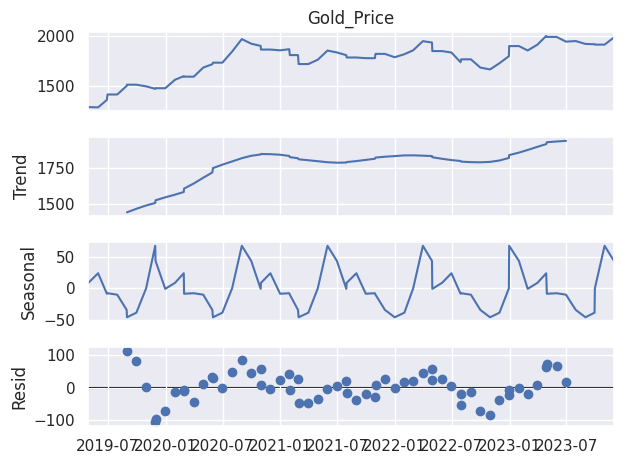

In [ ]:
result = seasonal_decompose(combined_df['Gold_Price'], model='additive', period=12)
result.plot()
plt.show()

Clearly see seasonality here.

In [ ]:
print("Check for Gold Stationarity")
result = adfuller(combined_df['Gold_Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# p-value is greater than 0.05, we need to difference the data.

Check for Gold Stationarity
ADF Statistic: -2.181414
p-value: 0.213060
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [ ]:
# Applying logarithmic transformation
combined_df['Gold_Price_Log'] = np.log(combined_df['Gold_Price'])

result_log = adfuller(combined_df['Gold_Price_Log'])
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

# Not working good

ADF Statistic: -2.405566
p-value: 0.140171
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [ ]:
combined_df['Gold_Price_diff'] = combined_df['Gold_Price_Log'].diff().dropna()

In [ ]:
selected_rows = combined_df.iloc[1:]
print("Check for Gold Stationarity after differencing and log")
result = adfuller(selected_rows['Gold_Price_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for Gold Stationarity after differencing and log
ADF Statistic: -6.140589
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


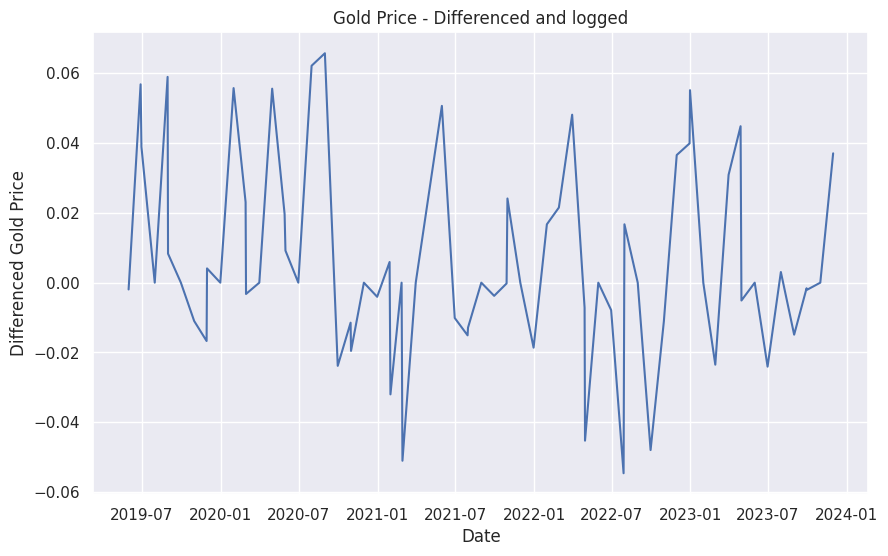

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Gold_Price_diff'])
plt.title('Gold Price - Differenced and logged')
plt.xlabel('Date')
plt.ylabel('Differenced Gold Price')
plt.show()

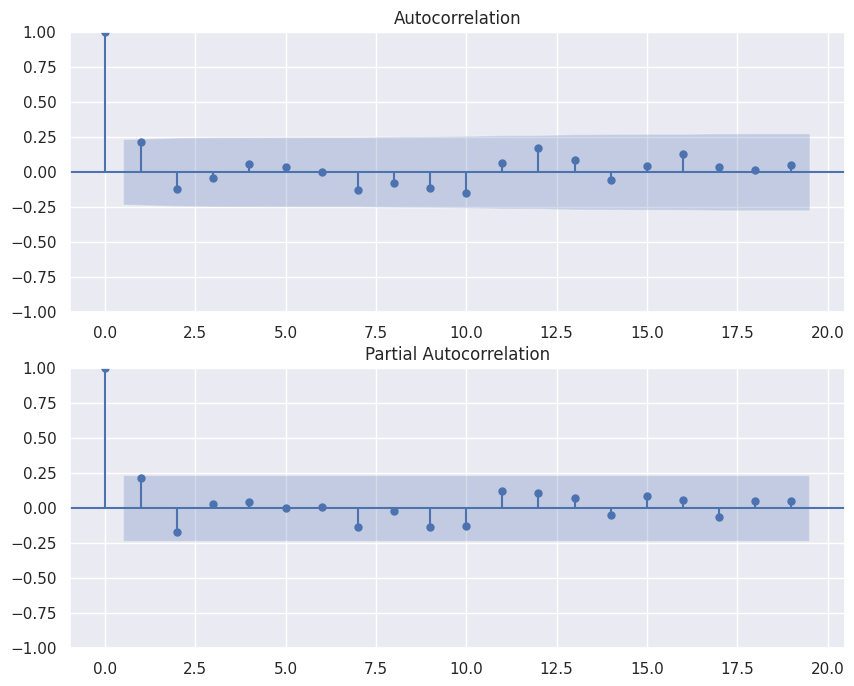

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['Gold_Price_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['Gold_Price_diff'].dropna(), ax=ax[1])
plt.show()

In [ ]:
print("Check for Fed Funds Stationarity")
result = adfuller(combined_df['Fed_Funds_Rate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for Fed Funds Stationarity
ADF Statistic: 0.296188
p-value: 0.977169
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


In [ ]:
# Applying logarithmic transformation
combined_df['Fed_Funds_Rate_Log'] = np.log(combined_df['Fed_Funds_Rate'])

result_log = adfuller(combined_df['Fed_Funds_Rate_Log'])
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.992304
p-value: 0.756061
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


In [ ]:
combined_df['Fed_Funds_Rate_diff'] = combined_df['Fed_Funds_Rate_Log'].diff().dropna()

In [ ]:
selected_rows = combined_df.iloc[1:]
print("Check for Fed_Funds_Rate Stationarity after differencing and log")
result = adfuller(selected_rows['Fed_Funds_Rate_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for Fed_Funds_Rate Stationarity after differencing and log
ADF Statistic: -6.869107
p-value: 0.000000
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


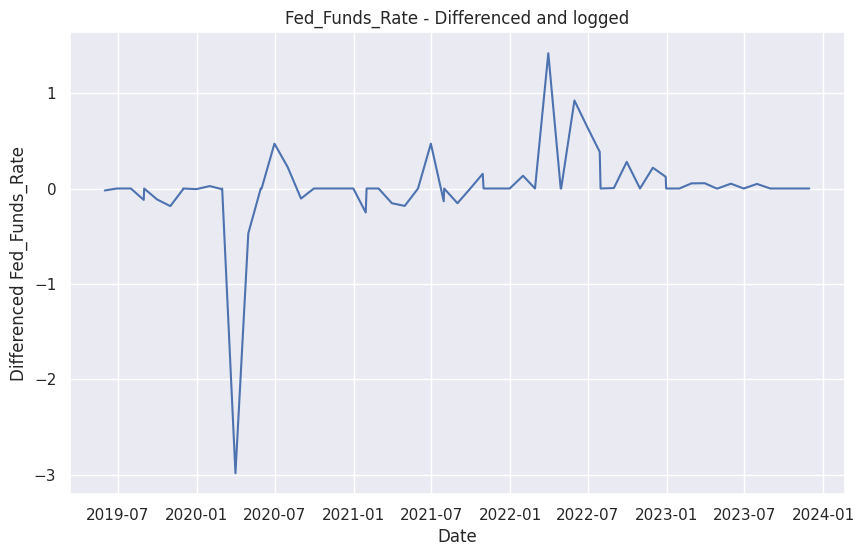

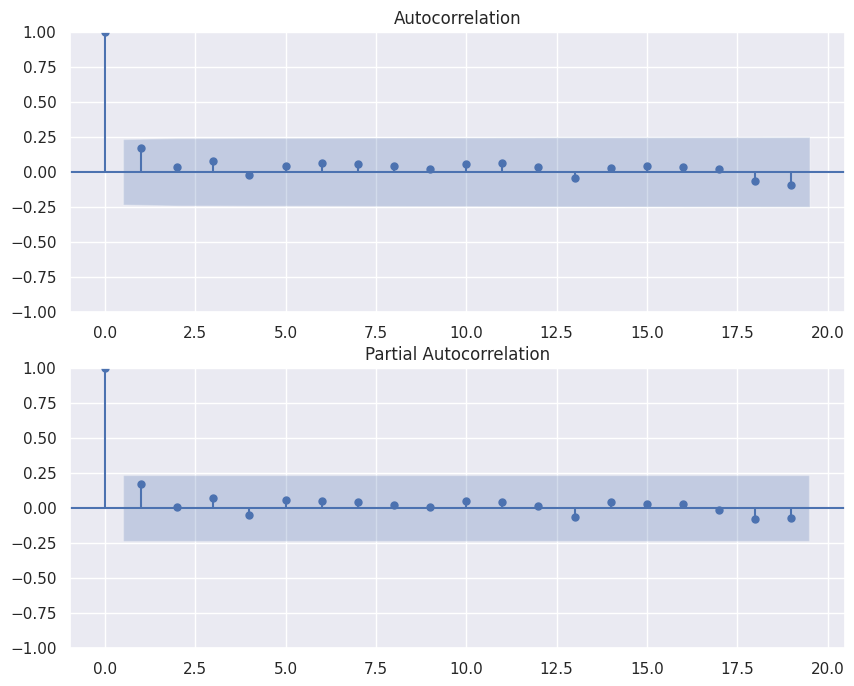

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Fed_Funds_Rate_diff'])
plt.title('Fed_Funds_Rate - Differenced and logged')
plt.xlabel('Date')
plt.ylabel('Differenced Fed_Funds_Rate')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['Fed_Funds_Rate_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['Fed_Funds_Rate_diff'].dropna(), ax=ax[1])
plt.show()

In [ ]:
print("Check for CPI Stationarity")
result = adfuller(combined_df['CPI'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for CPI Stationarity
ADF Statistic: -1.347080
p-value: 0.607368
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


In [ ]:
combined_df['CPI_Log'] = np.log(combined_df['CPI'])
combined_df['CPI_diff'] = combined_df['CPI_Log'].diff().dropna()

In [ ]:
selected_rows = combined_df.iloc[1:]
print("Check for CPI Stationarity after differencing and log")
result = adfuller(selected_rows['CPI_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for CPI Stationarity after differencing and log
ADF Statistic: -6.965347
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


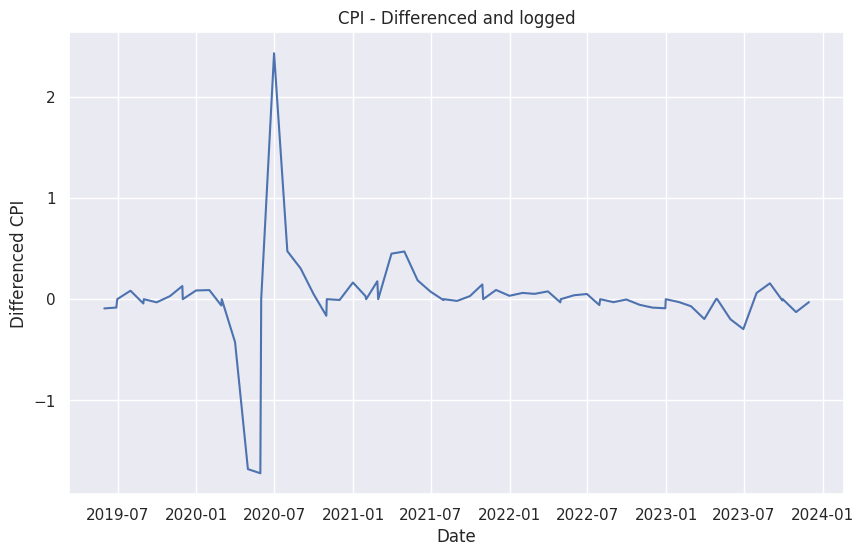

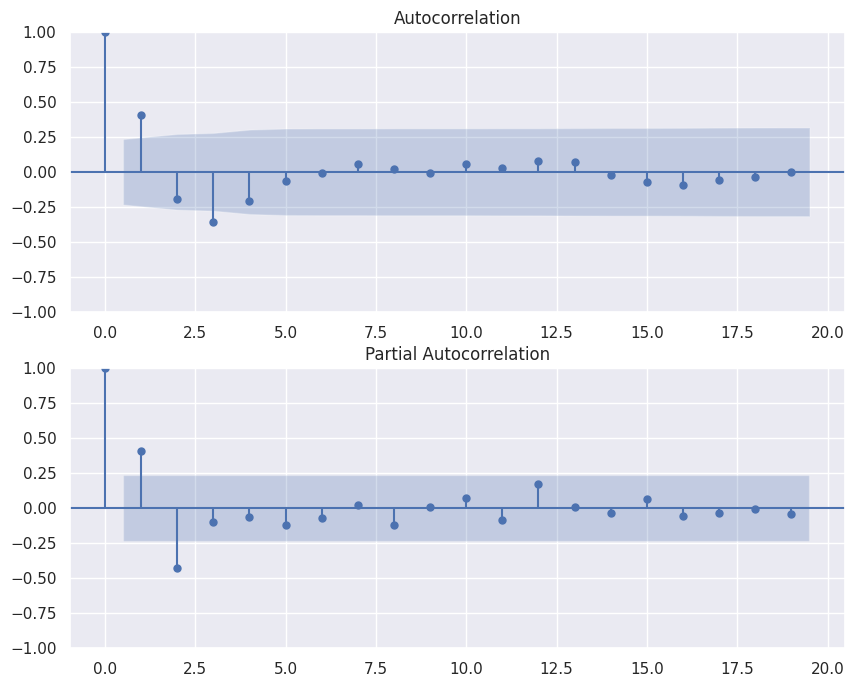

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['CPI_diff'])
plt.title('CPI - Differenced and logged')
plt.xlabel('Date')
plt.ylabel('Differenced CPI')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['CPI_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['CPI_diff'].dropna(), ax=ax[1])
plt.show()

In [ ]:
print("Check for SP500 Stationarity")
result = adfuller(combined_df['SP500'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for SP500 Stationarity
ADF Statistic: -1.288785
p-value: 0.634288
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [ ]:
# Applying logarithmic transformation
combined_df['SP500_Log'] = np.log(combined_df['SP500'])

result_log = adfuller(combined_df['SP500_Log'])
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.350328
p-value: 0.605844
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [ ]:
combined_df['SP500_diff'] = combined_df['SP500_Log'].diff().dropna()
selected_rows = combined_df.iloc[1:]
print("Check for SP500 Stationarity after differencing and log")
result = adfuller(selected_rows['SP500_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for SP500 Stationarity after differencing and log
ADF Statistic: -9.853761
p-value: 0.000000
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


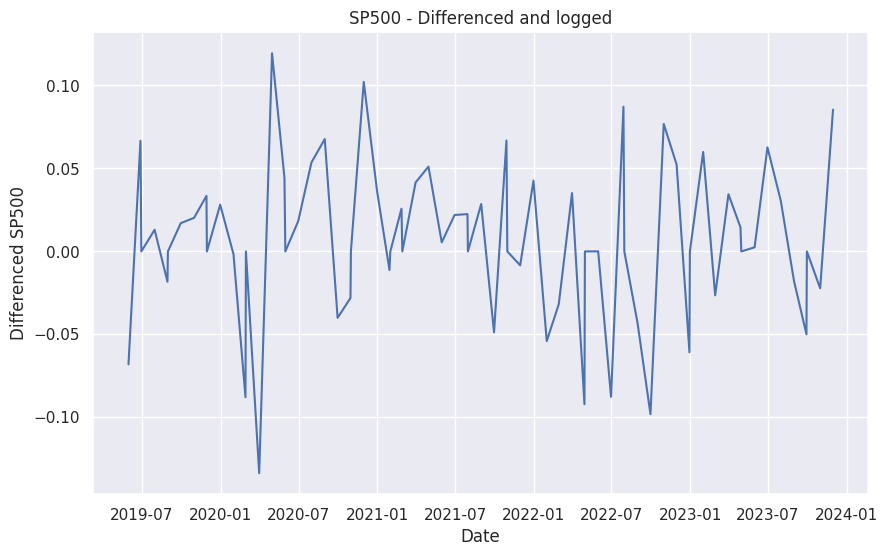

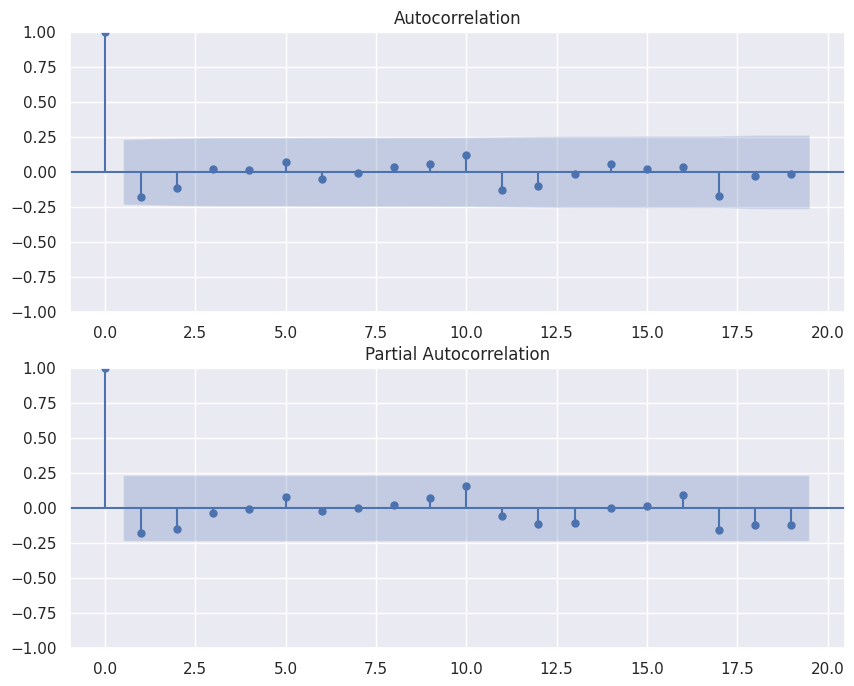

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['SP500_diff'])
plt.title('SP500 - Differenced and logged')
plt.xlabel('Date')
plt.ylabel('Differenced SP500')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['SP500_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['SP500_diff'].dropna(), ax=ax[1])
plt.show()

In [ ]:
print("Check for WTI_OIL Stationarity")
result = adfuller(combined_df['WTI_OIL'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for WTI_OIL Stationarity
ADF Statistic: -1.308917
p-value: 0.625083
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [ ]:
combined_df['WTI_OIL_Log'] = np.log(combined_df['WTI_OIL'])
combined_df['WTI_OIL_diff'] = combined_df['WTI_OIL_Log'].diff().dropna()
selected_rows = combined_df.iloc[1:]
print("Check for WTI_OIL Stationarity after differencing and log")
result = adfuller(selected_rows['WTI_OIL_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for WTI_OIL Stationarity after differencing and log
ADF Statistic: -7.220938
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


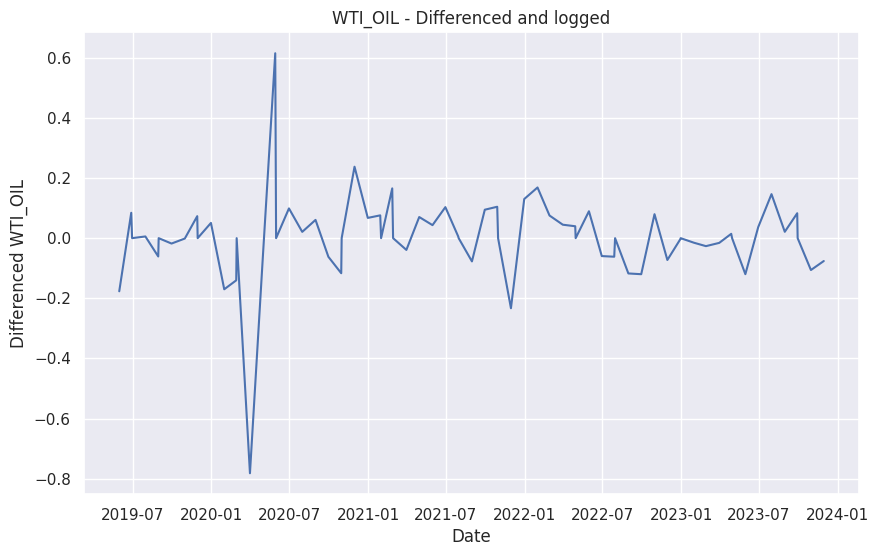

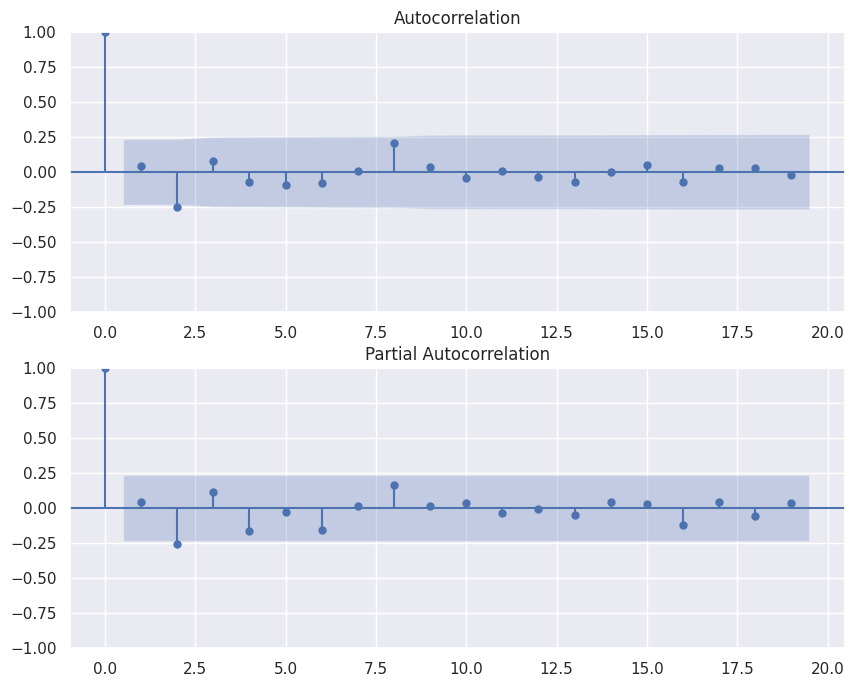

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['WTI_OIL_diff'])
plt.title('WTI_OIL - Differenced and logged')
plt.xlabel('Date')
plt.ylabel('Differenced WTI_OIL')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['WTI_OIL_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['WTI_OIL_diff'].dropna(), ax=ax[1])
plt.show()

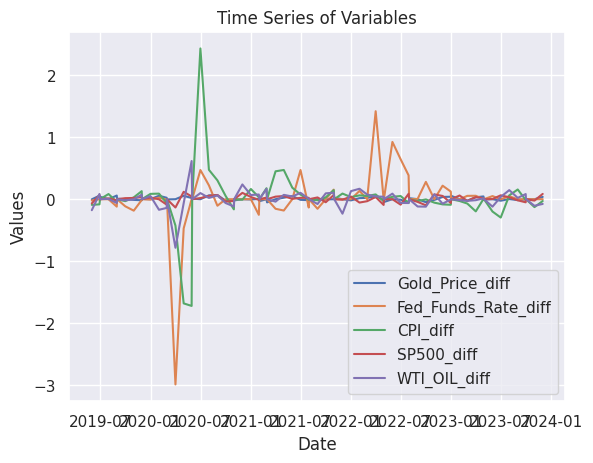

In [ ]:
plt.plot(combined_df['Gold_Price_diff'], label='Gold_Price_diff')
plt.plot(combined_df['Fed_Funds_Rate_diff'], label='Fed_Funds_Rate_diff')
plt.plot(combined_df['CPI_diff'], label='CPI_diff')
plt.plot(combined_df['SP500_diff'], label='SP500_diff')
plt.plot(combined_df['WTI_OIL_diff'], label='WTI_OIL_diff')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()

# Show the plot
plt.show()

## Time-Series Modeling

#### ARIMAX

In [ ]:
combined_df_diff = combined_df[["Gold_Price_diff", "Fed_Funds_Rate_diff", "CPI_diff", "SP500_diff", "WTI_OIL_diff"]]
combined_df_diff

,Gold_Price_diff,Fed_Funds_Rate_diff,CPI_diff,SP500_diff,WTI_OIL_diff
Date,,,,,
2019-04-30,NaN,NaN,NaN,NaN,NaN
2019-05-31,-0.001945,-0.020619,-0.091204,-0.068041,-0.176729
2019-06-28,0.056837,0.000000,-0.082623,0.066658,0.084391
2019-06-30,0.038922,0.000000,0.000000,0.000000,0.000000
2019-07-31,0.000000,0.000000,0.083410,0.013043,0.005654
...,...,...,...,...,...
2023-08-31,-0.014899,0.000000,0.156613,-0.017875,0.021168
2023-09-29,-0.001600,0.000000,-0.012582,-0.049946,0.082884
2023-09-30,-0.002047,0.000000,0.000000,0.000000,0.000000


In [ ]:
combined_df_diff.dropna(inplace=True)

train, test = train_test_split(combined_df_diff, shuffle=False, test_size=0.2)

model=pm.auto_arima(train['Gold_Price_diff'],start_p=0,d=0,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=0, start_Q=0, max_P=5,max_D=5,
          max_Q=5, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,
          random_state=20,n_fits=200)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-235.325, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-236.641, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-237.691, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-235.831, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-235.901, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-233.947, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-237.259, Time=0.13 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.543 seconds


In [ ]:
combined_df_diff.dropna(inplace=True)

train, test = train_test_split(combined_df_diff, shuffle=False, test_size=0.2)

endog = train['Gold_Price_diff']
exog = train[['Fed_Funds_Rate_diff', 'CPI_diff', 'SP500_diff', 'WTI_OIL_diff']]

# Fit the ARIMAX model
model = SARIMAX(endog, exog=exog, order=(0,0,1), seasonal_order=(0,0,0,0))
results = model.fit()

print(results.summary())

start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, exog=test[['Fed_Funds_Rate_diff', 'CPI_diff', 'SP500_diff', 'WTI_OIL_diff']])
print(predictions)

                               SARIMAX Results                                
Dep. Variable:        Gold_Price_diff   No. Observations:                   56
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 122.132
Date:                Fri, 17 May 2024   AIC                           -232.265
Time:                        15:06:52   BIC                           -220.113
Sample:                             0   HQIC                          -227.554
                                 - 56                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Fed_Funds_Rate_diff     0.0018      0.011      0.166      0.869      -0.020       0.024
CPI_diff               -0.0067      0.013     -0.509      0.611      -0.033       0.019
SP500_diff      

Model Description
Dep. Variable: Gold_Price_diff - This indicates that the model is predicting the differences in gold prices.
Model: SARIMAX(0, 0, 1) - This specifies that the model is a Seasonal ARIMA model with no autoregressive terms (p=0), no differencing (d=0), and one moving average term (q=1). There are no seasonal components in this model (P=D=Q=s=0).
No. Observations: 56 - The model was trained on 56 data points.
Fit Statistics
Log Likelihood: 122.132 - This is a measure of the likelihood of the model given the data, where higher values generally indicate a better model fit.
AIC: -232.265 - The Akaike Information Criterion, which balances model complexity and goodness of fit, with lower values indicating a better model.
BIC: -220.113 - The Bayesian Information Criterion, similar to AIC but with a stronger penalty for model complexity.
Coefficients
Fed_Funds_Rate_diff: Coefficient = 0.0018, p-value = 0.869 - This suggests that changes in the Federal Funds Rate have a very small and statistically insignificant effect on changes in gold prices.
CPI_diff: Coefficient = -0.0067, p-value = 0.611 - Changes in the Consumer Price Index also appear to have an insignificant effect on gold price changes.
SP500_diff: Coefficient = 0.0947, p-value = 0.189 - Changes in the S&P 500 index have a positive effect on gold price changes, but this effect is not statistically significant.
WTI_OIL_diff: Coefficient = -0.0073, p-value = 0.859 - Changes in WTI oil prices have a negligible and statistically insignificant effect on changes in gold prices.
ma.L1: Coefficient = 0.3052, p-value = 0.048 - The moving average component of the model is significant, suggesting that past errors (lags of the forecast errors) are useful predictors of the current value.
Diagnostic Tests
Ljung-Box Test: Prob(Q) = 0.79 - This test checks for autocorrelation in the residuals of the model. A high p-value suggests that there is no significant autocorrelation.
Jarque-Bera Test: Prob(JB) = 1.00 - This test checks for normality in the distribution of residuals. A high p-value here suggests that the residuals are normally distributed.
Heteroskedasticity Test: Prob(H) = 0.69 - This tests whether the variance of the residuals is constant across the data. A high p-value suggests that heteroskedasticity is not present.
Conclusion
The model indicates that none of the included exogenous variables significantly predict changes in gold prices, except for a marginal effect from the moving average component of the model. The diagnostics suggest that the model residuals do not violate the assumptions of no autocorrelation, normality, or constant variance.

Given these results, you might consider exploring other variables, adding complexity to the model (like integrating AR terms if justified), or using different types of models to better capture the dynamics influencing gold price changes.

We fail to reject the null hypothesis of the Ljung-Box test, it means that there is not enough statistical evidence to conclude that there is autocorrelation in the residuals at any of the lags tested. It suggests that the model has adequately captured the dependencies in the data, leaving residuals that resemble white noise (random fluctuations).

In [ ]:
# combined_df_diff.dropna(inplace=True)

# train, test = train_test_split(combined_df_diff, shuffle=False, test_size=0.2)

# endog = train['Gold_Price_diff']
# exog = train[['Fed_Funds_Rate_diff', 'CPI_diff', 'SP500_diff', 'WTI_OIL_diff']]

# # Fit the ARIMAX model
# model = SARIMAX(endog, exog=exog, order=(0,0,1), seasonal_order=(0,0,0,0))
# results = model.fit()

# print(results.summary())

# start = len(train)
# end = len(train) + len(test) - 1
# predictions = results.predict(start=start, end=end, exog=test[['Fed_Funds_Rate_diff', 'CPI_diff', 'SP500_diff', 'WTI_OIL_diff']])
# print(predictions)

In [ ]:
# Cumulative sum of predictions + last known log price
cumulative_log_price = np.cumsum(predictions) + 7.548887852439474

# Exponentiate to get back to original price scale
predicted_prices = np.exp(cumulative_log_price)

print(predicted_prices)

56    1919.012394
57    1930.517396
58    1927.156802
59    1936.425416
60    1938.838798
61    1938.838798
62    1943.764468
63    1958.715175
64    1961.678385
65    1955.995418
66    1945.761211
67    1945.761211
68    1944.833888
69    1962.096998
Name: predicted_mean, dtype: float64


In [ ]:
combined_df[["Gold_Price"]].tail(14)

,Gold_Price
Date,
2022-12-31,1898.63
2023-01-31,1898.63
2023-02-28,1854.54
2023-03-31,1912.73
2023-04-28,2000.42
2023-04-30,1990.22
2023-05-31,1990.22
2023-06-30,1942.90
2023-07-31,1948.85


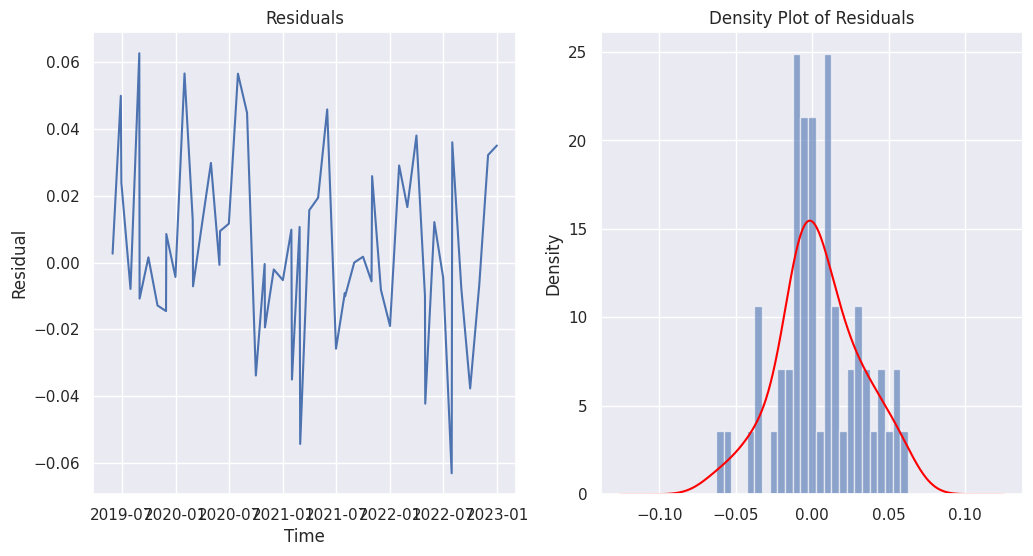

In [ ]:
# Plot residuals
residuals = results.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residual')

# Histogram plus estimated density
ax[1].hist(residuals, bins=25, density=True, alpha=0.6, color='b')
residuals.plot(kind='kde', ax=ax[1], color='red')
ax[1].set_title('Density Plot of Residuals')

plt.show()

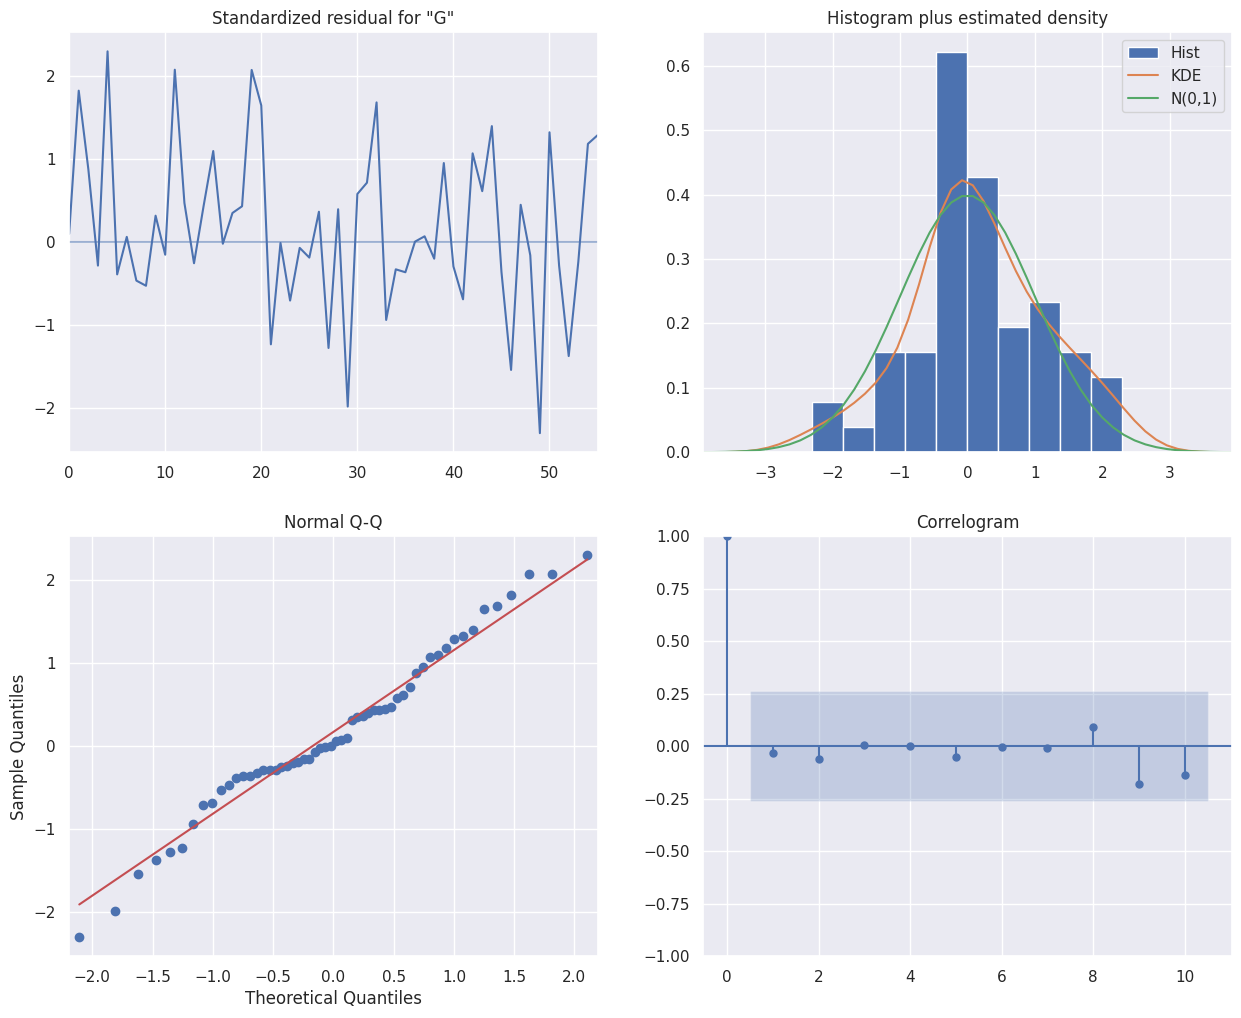

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Results (accuracy) and learnings from the methodology

In [ ]:
predicted_dates = [
    "2022-12-31", "2023-01-31", "2023-02-28", "2023-03-31",
    "2023-04-28", "2023-04-30", "2023-05-31", "2023-06-30",
    "2023-07-31", "2023-08-31", "2023-09-29", "2023-09-30",
    "2023-10-31", "2023-11-30"
]

predicted_dates = pd.to_datetime(predicted_dates)

predicted_prices.index = predicted_dates

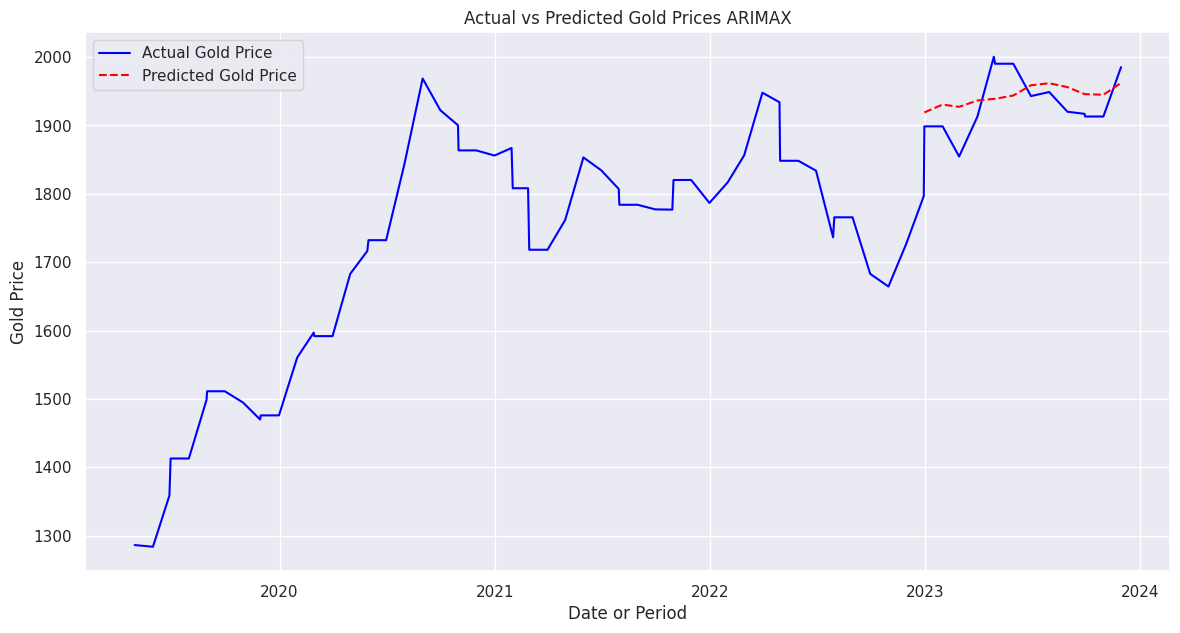

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(combined_df['Gold_Price'], label='Actual Gold Price', color='blue')

plt.plot(predicted_prices.index, predicted_prices, label='Predicted Gold Price', color='red', linestyle='--')

plt.title('Actual vs Predicted Gold Prices ARIMAX')
plt.xlabel('Date or Period')
plt.ylabel('Gold Price')

plt.legend()

plt.show()

In [ ]:
actual_prices = combined_df.loc[predicted_prices.index, 'Gold_Price']

In [ ]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 34.93558811104661
Mean Squared Error (MSE): 1500.966767139674
Root Mean Squared Error (RMSE): 38.74231236180507


#### Drift method

Mean Absolute Error (MAE): 336.07
Root Mean Squared Error (RMSE): 360.54
Mean Absolute Percentage Error (MAPE): 18.08%


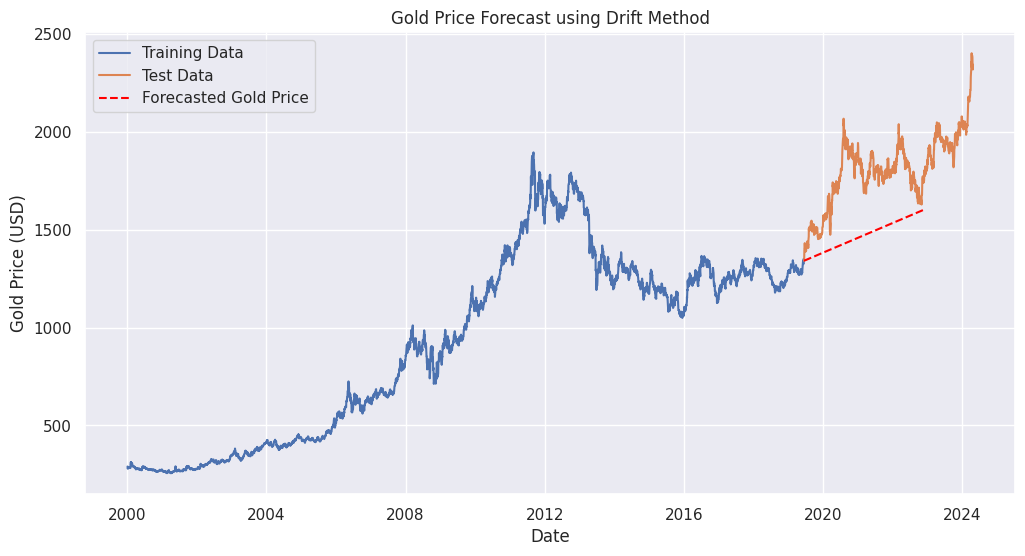

In [ ]:
gold_price_daily = pd.read_excel("gold_price_daily.xlsx")
gold_price_daily = gold_price_daily.iloc[5481:]

# Split training and test 80/20
train_size = int(0.8 * len(gold_price_daily))
train_data = gold_price_daily.iloc[:train_size]
test_data = gold_price_daily.iloc[train_size:]

# Calculate the drift from the training
n = len(train_data)
first_value = train_data['y'].iloc[0]
last_value = train_data['y'].iloc[-1]
drift_per_day = (last_value - first_value) / (n - 1)

# Forecast future values for the test set using the drift
forecast_days = len(test_data)
last_date = pd.to_datetime(train_data['ds'].iloc[-1])
forecast_dates = pd.date_range(start=last_date, periods=forecast_days + 1, freq='D')[1:]
forecast_prices = [last_value + i * drift_per_day for i in range(1, forecast_days + 1)]

# Calculate the error metrics
actual_prices = test_data['y'].values
mae = mean_absolute_error(actual_prices, forecast_prices)
rmse = mean_squared_error(actual_prices, forecast_prices, squared=False)
mape = np.mean(np.abs((actual_prices - forecast_prices) / actual_prices)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data')
plt.plot(test_data['ds'], test_data['y'], label='Test Data')
plt.plot(forecast_dates, forecast_prices, label='Forecasted Gold Price', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.title('Gold Price Forecast using Drift Method')
plt.legend()
plt.grid(True)
plt.show()

### Prophet with direct forecasting

In [ ]:
gold_price_daily = pd.read_excel("gold_price_daily.xlsx")
gold_price_daily = gold_price_daily.iloc[5481:]
gold_price_daily.reset_index(inplace=True)
gold_price_daily = gold_price_daily.drop(['index'], axis=1)

In [ ]:
gold_price_daily

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10
...,...,...
6340,2024-04-22,2334.95
6341,2024-04-23,2328.45
6342,2024-04-24,2320.25
6343,2024-04-25,2318.70


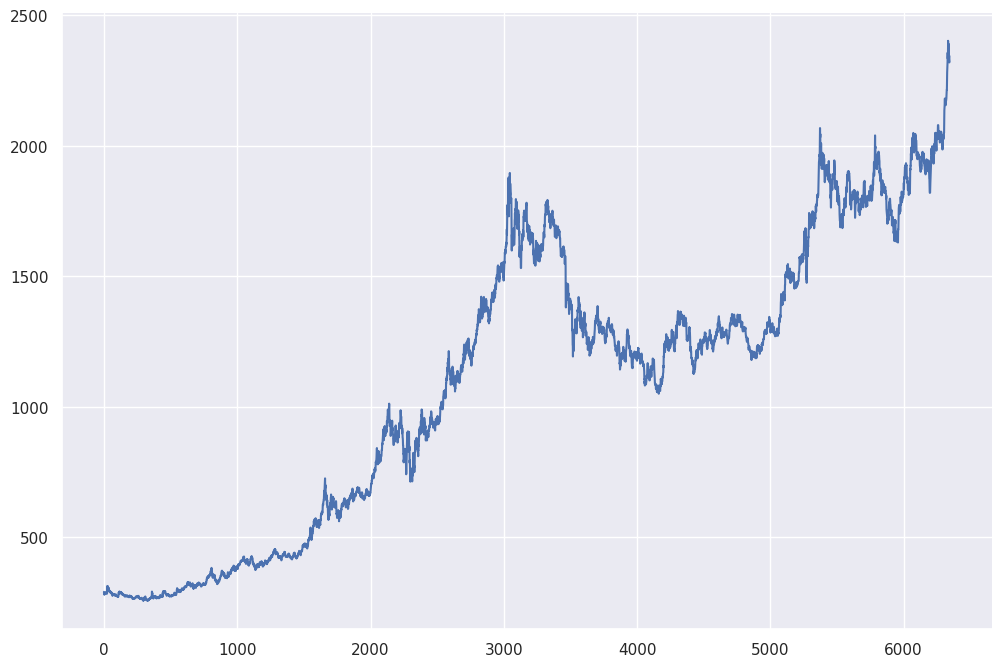

In [ ]:
# @title y

from matplotlib import pyplot as plt
gold_price_daily['y'].plot(kind='line', figsize=(12, 8))
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Prophet
model = Prophet()
model.fit(gold_price_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpope16ksu/q5k7tr_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpope16ksu/f_bcc33w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50282', 'data', 'file=/tmp/tmpope16ksu/q5k7tr_8.json', 'init=/tmp/tmpope16ksu/f_bcc33w.json', 'output', 'file=/tmp/tmpope16ksu/prophet_modeldt_7biv2/prophet_model-20240517150659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:06:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:07:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
6705,2025-04-22
6706,2025-04-23
6707,2025-04-24
6708,2025-04-25
6709,2025-04-26


In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6705,2025-04-22,2201.448555,2068.775906,2327.255321
6706,2025-04-23,2200.889469,2065.663841,2324.550657
6707,2025-04-24,2200.386443,2070.333639,2321.705532
6708,2025-04-25,2199.996407,2069.096019,2318.362228
6709,2025-04-26,2208.390264,2082.767278,2330.536462


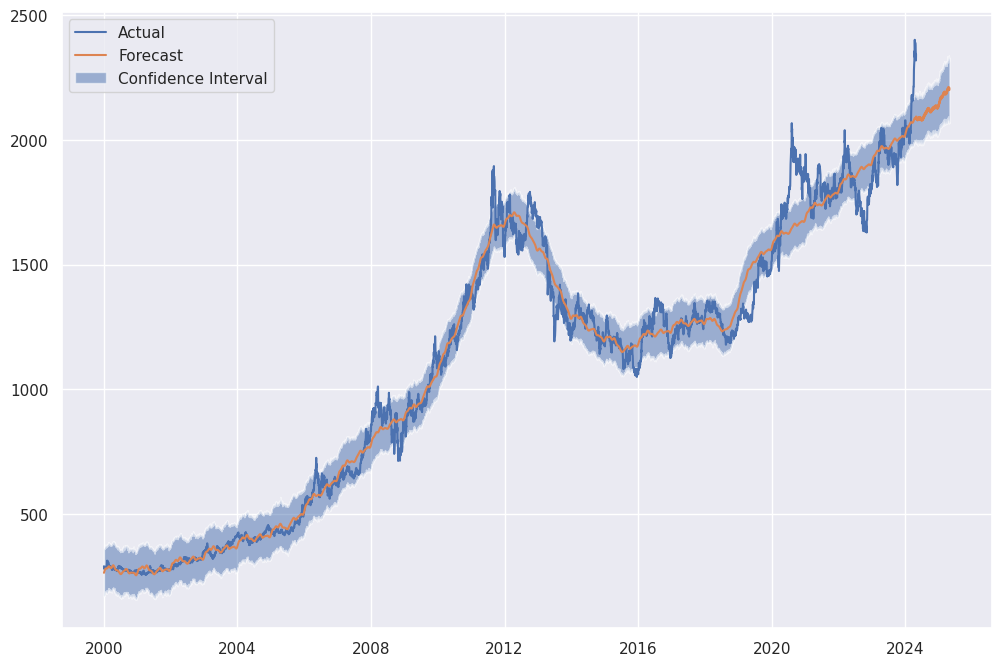

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(gold_price_daily['ds'], gold_price_daily['y'], label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.5, label='Confidence Interval')
ax.legend()
plt.show()

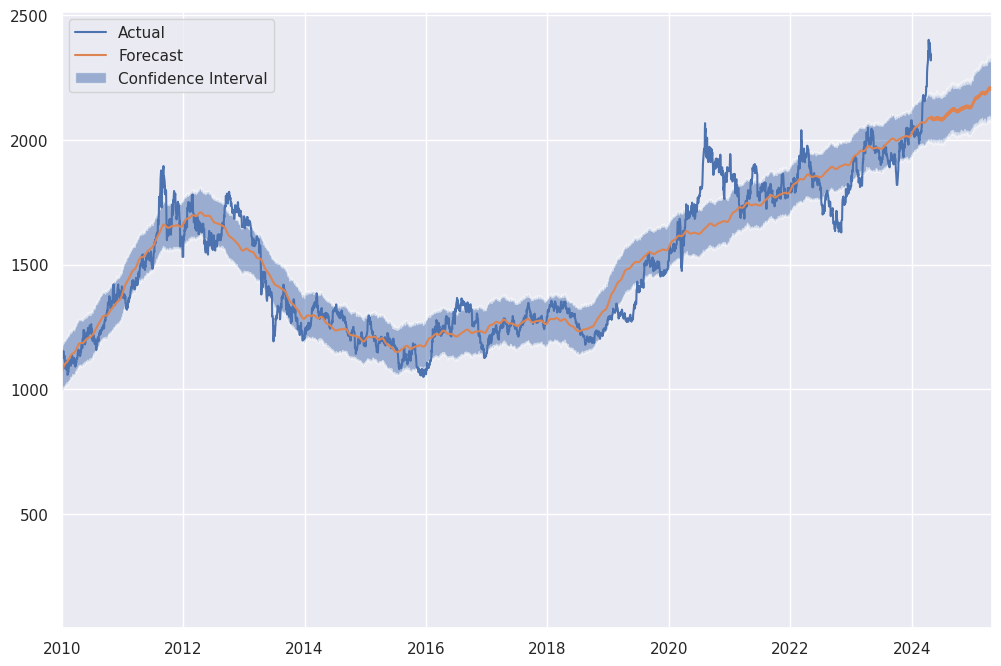

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(gold_price_daily['ds'], gold_price_daily['y'], label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.5, label='Confidence Interval')

start_date = pd.to_datetime('2010-01-01')
end_date = forecast['ds'].max()

if not isinstance(end_date, pd.Timestamp):
    end_date = pd.to_datetime(end_date)

ax.set_xlim([start_date, end_date])

ax.legend()
plt.show()

### Prophet with train/test split forecasting

In [ ]:
gold_price_daily = pd.read_excel("gold_price_daily.xlsx")
gold_price_daily = gold_price_daily.iloc[5481:]
gold_price_daily.reset_index(inplace=True)
gold_price_daily = gold_price_daily.drop(['index'], axis=1)
train = gold_price_daily[:-365]
test = gold_price_daily[-365:]
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpope16ksu/e0kwbk8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpope16ksu/b0ytm7z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27404', 'data', 'file=/tmp/tmpope16ksu/e0kwbk8f.json', 'init=/tmp/tmpope16ksu/b0ytm7z4.json', 'output', 'file=/tmp/tmpope16ksu/prophet_modelhdq0d50l/prophet_model-20240517150708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
predicted = forecast[-365:]['yhat']
actual = test['y']

mae = mean_absolute_error(actual, predicted)
rmse = mean_squared_error(actual, predicted, squared=False)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # MAPE

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


MAE: 96.21898888953442
RMSE: 112.19681650299636
MAPE: 4.895163998189626%


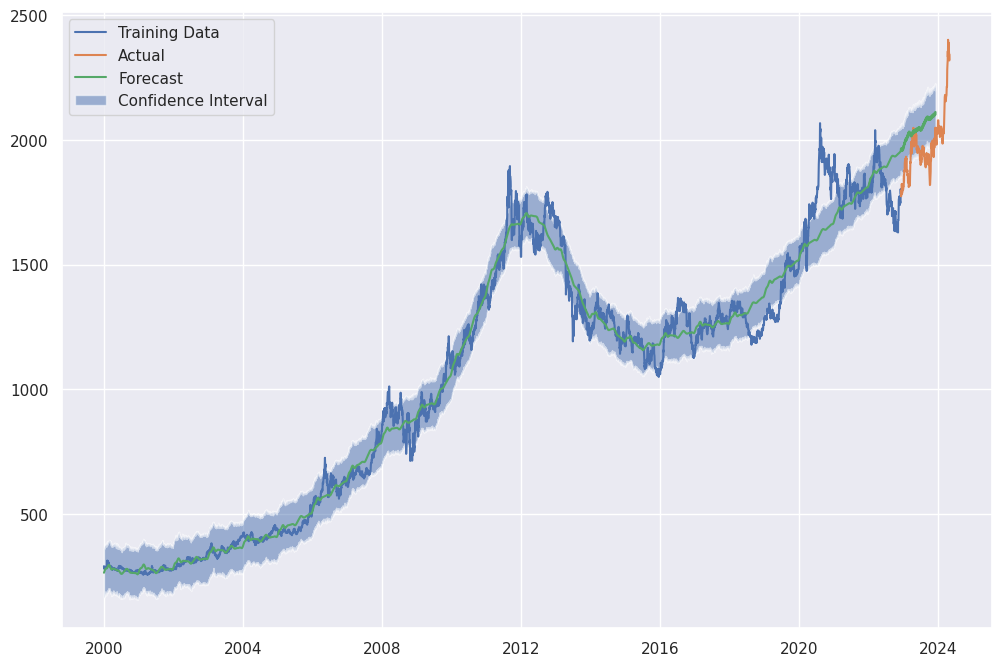

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train['ds'], train['y'], label='Training Data')
ax.plot(test['ds'], actual, label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.5, label='Confidence Interval')
ax.legend()
plt.show()


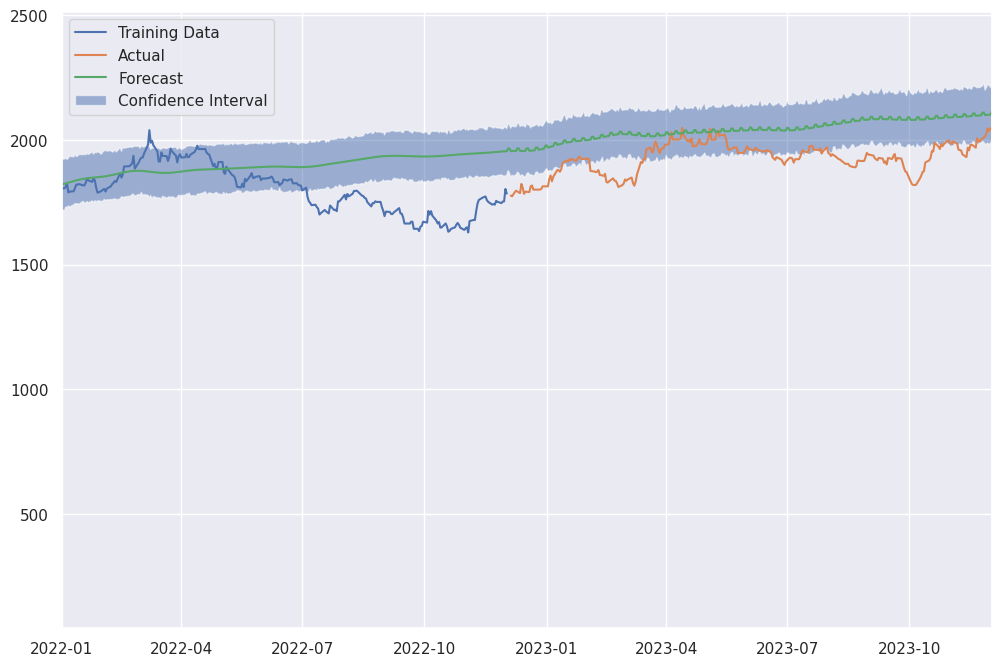

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train['ds'], train['y'], label='Training Data')
ax.plot(test['ds'], actual, label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.5, label='Confidence Interval')

start_date = pd.to_datetime('2022-01-01')
end_date = forecast['ds'].max()

if not isinstance(end_date, pd.Timestamp):
    end_date = pd.to_datetime(end_date)

ax.set_xlim([start_date, end_date])

ax.legend()
plt.show()

### GARCH (for volatility)

In [ ]:
gold_price_daily = pd.read_excel("gold_price_daily.xlsx")
gold_price_daily = gold_price_daily.iloc[5481:]
gold_price_daily.reset_index(inplace=True)
gold_price_daily = gold_price_daily.drop(['index'], axis=1)
# gold_price_daily['ds'] = gold_price_daily['ds'].dt.strftime('%Y-%m-%d')

In [ ]:
gold_price_daily.head()

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10


In [ ]:
# Convert prices to log returns
gold_price_daily['Log Return'] = np.pad(np.diff(np.log(gold_price_daily['y'])) * 100, (1, 0), 'constant', constant_values=np.nan)
gold_price_daily.head()

,ds,y,Log Return
0,2000-01-03,290.25,NaN
1,2000-01-04,281.50,-3.061017
2,2000-01-05,280.45,-0.373699
3,2000-01-06,279.40,-0.375101
4,2000-01-07,282.10,0.961717


Text(0.5, 1.0, 'Gold Log Return')

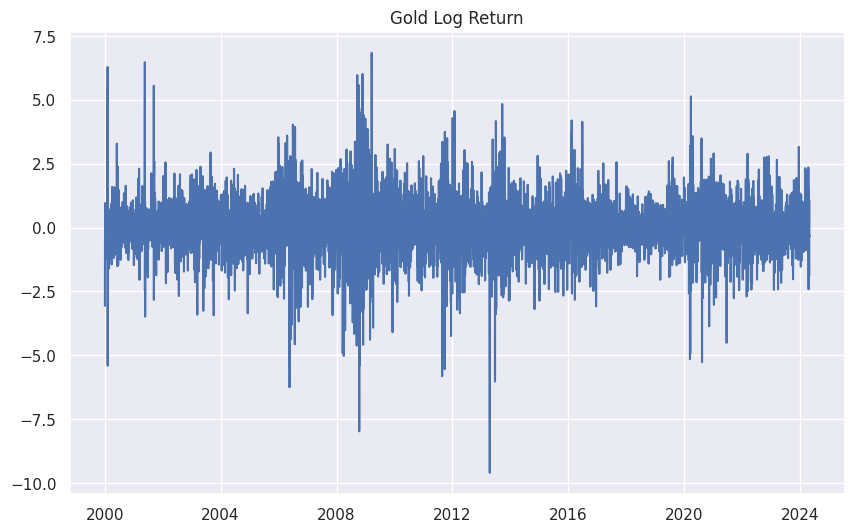

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(gold_price_daily['ds'], gold_price_daily['Log Return'])
plt.title('Gold Log Return')

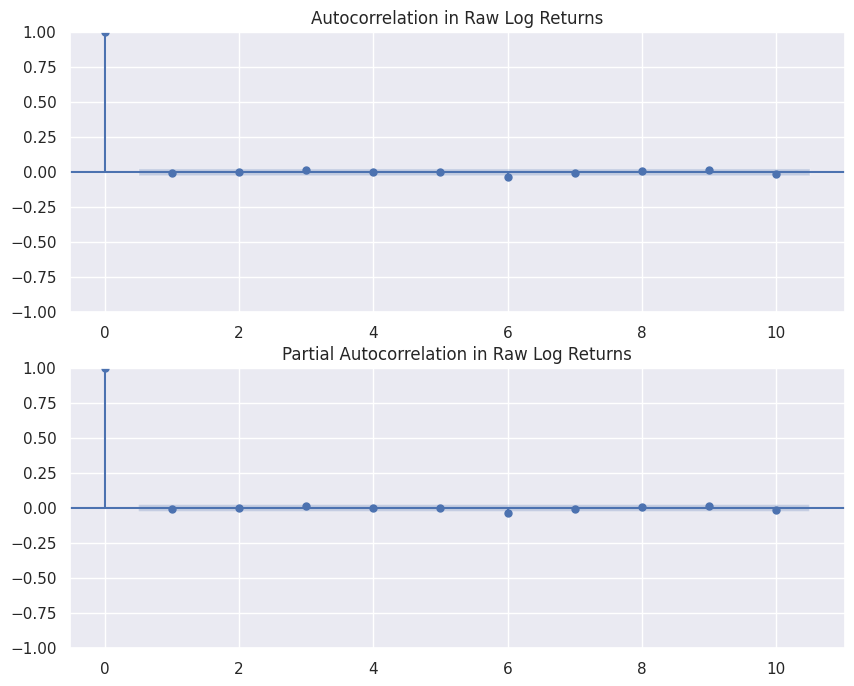

In [ ]:
diff_ts = gold_price_daily['Log Return'].iloc[1:]
# ACF and PACF for raw log returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts.dropna(), ax=ax1, lags=10)
ax1.set_title("Autocorrelation in Raw Log Returns")
plot_pacf(diff_ts.dropna(), ax=ax2, lags=10)
ax2.set_title("Partial Autocorrelation in Raw Log Returns")
plt.show();

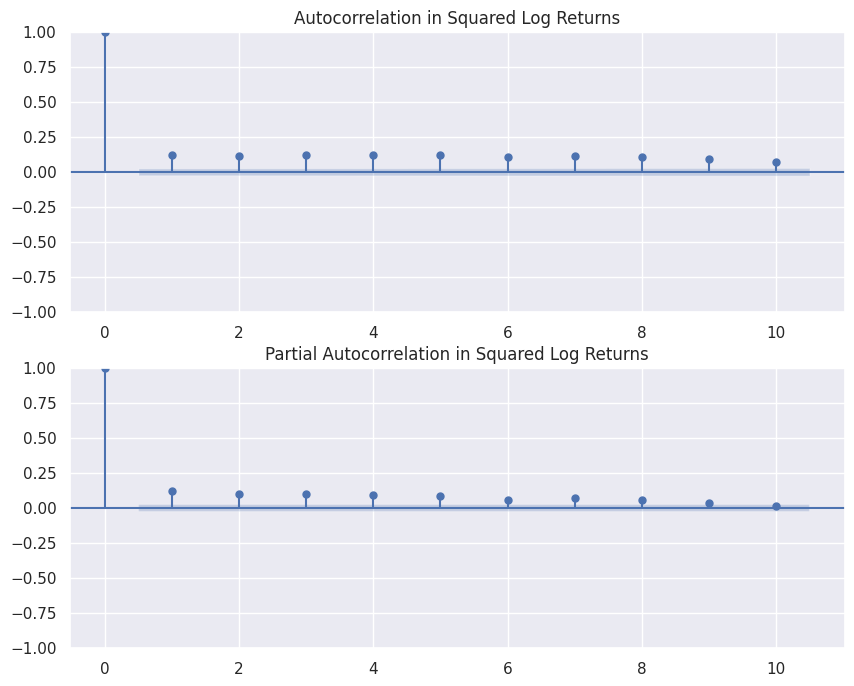

In [ ]:
# Calculate squared log returns
gold_price_daily['Squared Returns'] = gold_price_daily['Log Return'] ** 2

# ACF and PACF for squared log returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(gold_price_daily['Squared Returns'].dropna(), ax=ax1, lags=10)
ax1.set_title("Autocorrelation in Squared Log Returns")
plot_pacf(gold_price_daily['Squared Returns'].dropna(), ax=ax2, lags=10)
ax2.set_title("Partial Autocorrelation in Squared Log Returns")
plt.show();

In [ ]:
# McLeod-Li test function
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

In [ ]:
test_stat, p_value = mcleod_li_test(diff_ts, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

McLeod-Li test statistic:  5719.68410349655
p-value:  0.0


From the p-value, we can reject the null hypothesis, confirming the presence of conditional heteroskedasticity or volatility clustering.gold_price_daily['Log Return'].iloc[1:]

In [ ]:
y_train, y_test = train_test_split(diff_ts, train_size=0.8, random_state=42)

# Reset index for y_train and y_test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
# 80% training and 20% testing
y_train, y_test = train_test_split(diff_ts, train_size= 0.8)

In [ ]:
y_train

2197    0.482202
5287   -0.087957
6002    0.759350
5890    1.077780
43     -1.029522
          ...   
2306    1.597858
5545    0.000000
5436    0.968888
6023   -0.220920
4970   -0.362750
Name: Log Return, Length: 5075, dtype: float64

In [ ]:
# function to fit different models
def fit_model(data, model_type, p, q):
    model = arch_model(data, mean='Zero', vol=model_type, p=p, q=q)
    res = model.fit()
    return res

models = {
    'ARCH(1)': fit_model(y_train, 'ARCH', p=1, q=0),
    'ARCH(2)': fit_model(y_train, 'ARCH', p=2, q=0),
    'GARCH(1,1)': fit_model(y_train, 'GARCH', p=1, q=1),
    'GARCH(2,2)': fit_model(y_train, 'GARCH', p=2, q=2)
}

Iteration:      1,   Func. Count:      4,   Neg. LLF: 11038.806146259496
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7480.295524283916
Iteration:      3,   Func. Count:     13,   Neg. LLF: 7484.238297808463
Iteration:      4,   Func. Count:     17,   Neg. LLF: 7479.132980956605
Iteration:      5,   Func. Count:     21,   Neg. LLF: 7479.082072509633
Iteration:      6,   Func. Count:     24,   Neg. LLF: 7479.073380673302
Iteration:      7,   Func. Count:     27,   Neg. LLF: 7479.073351004673
Iteration:      8,   Func. Count:     29,   Neg. LLF: 7479.073351005126
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7479.073351004673
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11038.806146213843
Iteration:      2,   Func. Count:     12,   Neg. LLF: 7480.090444989098
Iteration:      3,   Func. Count:     16,   Neg. LLF: 7482.35198167107


In [ ]:
for name, model in models.items():
    print(f"{name} Model Summary:")
    print(model.summary())
    print("\n")

ARCH(1) Model Summary:
                        Zero Mean - ARCH Model Results                        
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7479.07
Distribution:                  Normal   AIC:                           14962.1
Method:            Maximum Likelihood   BIC:                           14975.2
                                        No. Observations:                 5075
Date:                Fri, May 17 2024   Df Residuals:                     5075
Time:                        15:07:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.1060  4.815e-02

In [ ]:
# Select the best model based on AIC
best_aic = float('inf')
best_model = None
for name, model in models.items():
    if model.aic < best_aic:
        best_aic = model.aic
        best_model = name

print(f"The best model based on AIC is {best_model} with an AIC of {best_aic}.")

The best model based on AIC is ARCH(1) with an AIC of 14962.146702009346.


In [ ]:
garch_model = arch_model(y_train, mean='Zero', vol='ARCH', p=1, q=0)
garch_result = garch_model.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 11038.806146259496
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7480.295524283916
Iteration:      3,   Func. Count:     13,   Neg. LLF: 7484.238297808463
Iteration:      4,   Func. Count:     17,   Neg. LLF: 7479.132980956605
Iteration:      5,   Func. Count:     21,   Neg. LLF: 7479.082072509633
Iteration:      6,   Func. Count:     24,   Neg. LLF: 7479.073380673302
Iteration:      7,   Func. Count:     27,   Neg. LLF: 7479.073351004673
Iteration:      8,   Func. Count:     29,   Neg. LLF: 7479.073351005126
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7479.073351004673
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 8


In [ ]:
# Calculate the standardized residuals on the test data
std_resid = garch_result.resid / garch_result.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 8199.073899191371
p-value: 0.0


This extremely small p-value effectively rejects the null hypothesis that the standardized residuals are normally distributed. This result suggests that the residuals have either skewness, excess kurtosis, or both, which are not consistent with a normal distribution.

In [ ]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = diff_ts[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

In [ ]:
rolling_preds

2194    0.724399
4027    0.711389
1090    0.699895
2969    0.885076
5637    0.907502
          ...   
3707    1.050567
5588    1.111011
3218    1.084267
2374    1.059910
1289    1.033402
Length: 1269, dtype: float64

In [ ]:
# plt.plot(gold_price_daily['ds'][start_idx:], rolling_preds, label='Predicted Rolling Volatility', color='red')

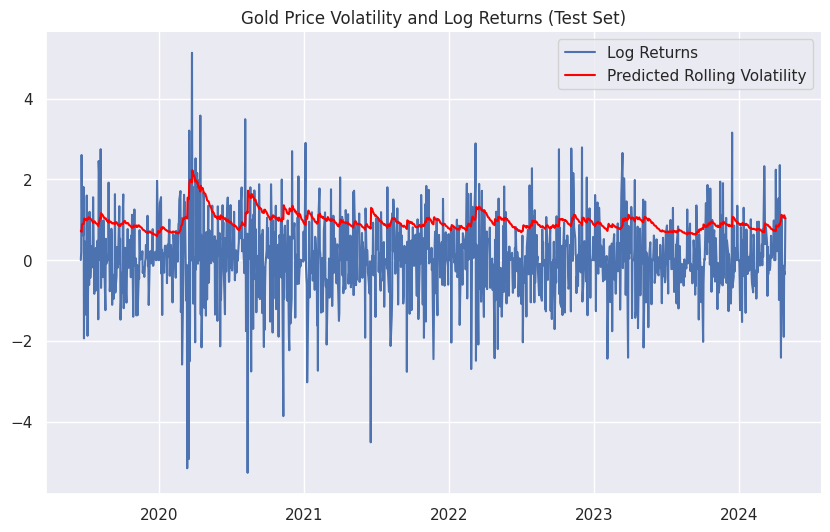

In [ ]:
start_idx = int(len(gold_price_daily) * 0.8)

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the absolute values of the actual log returns for the last 20%
ax.plot(gold_price_daily['ds'][start_idx:], gold_price_daily['Log Return'][start_idx:], label='Log Returns')

ax.plot(gold_price_daily['ds'][start_idx:], rolling_preds, label='Predicted Rolling Volatility', color='red', linestyle='-')

ax.set_title("Gold Price Volatility and Log Returns (Test Set)")
ax.legend(loc='upper right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    n = len(y_true)
    d = np.abs(np.diff(y_true)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

mase = mean_absolute_scaled_error(gold_price_daily['Log Return'][start_idx:], rolling_preds)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MASE: {mase}")


RMSE: 1.332397072065138
MAE: 1.070060158518971
MAPE: 647.5331369334
MASE: 1.0710418474408774


## Data Sources

“Gold Spot Price and Cost of Gold.” World Gold Council, www.gold.org/goldhub/data/gold-prices

“Federal Funds Effective Rate.” FRED, fred.stlouisfed.org/series/DFF

“NBER Based Recession Indicators for the United States from the Period Following the Peak through the Trough.” FRED, fred.stlouisfed.org/series/USREC

“S&P 500.” FRED, fred.stlouisfed.org/series/SP500.

“Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma.” FRED, fred.stlouisfed.org/series/DCOILWTICO.